# Q1

Given information:

P(Disease) = 1 / 10,000 = 0.0001

P(No Disease) = 1 - P(Disease) = 0.9999

P(Positive|Disease) = 0.99

P(Negative|No Disease) = 0.99

P(Positive|No Disease) = 1 - 0.99 = 0.01


**Try to find answer P(Disease|Positive)**

Solution:

1. P(Disease|Positive) = P(Positive|Disease)*P(Disease) / P(Positive) = 0.99 * 0.0001 / P(Positive)
2. Then the question is finding P(Positive)
3. P(Positive) = P(Positive|Disease) * P(Disease) + P(Positive|No Disease) * P(No Disease) = 0.99 * 0.0001 + 0.01 * 0.9999 = 0.010098
4. P(Disease|Positive) = 0.99 * 0.0001 / P(Positive) = 0.99 * 0.0001 / 0.010098 = 0.00980392157 ~= 0.01

**So the answer of the question is 0.98%, nearly 1% chances that you actually have this disease.**


# Q2

Import dataset





In [954]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

data = pd.read_csv('KaggleV2-May-2016.csv')

Data preprocessing -- Including data exploration (33 pts)


I utilized several features for training my model.

["Age", "Neighbourhood", "Scholarship", "AppointmentDiff", "SMS_received"]

**Gender**

Missing value detection

In [955]:
print(f"Number of missing value for Gender is {data['Gender'].isna().sum()}")

Number of missing value for Gender is 0


Distribution and relationship to the target

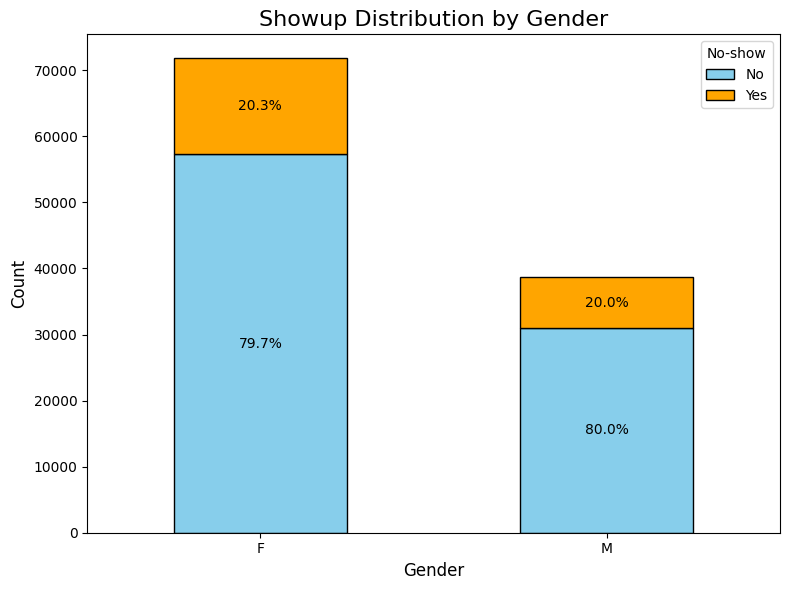

In [956]:
# Calculate counts for each combination of gender and showup
counts = data.groupby(['Gender', 'No-show']).size().unstack(fill_value=0)

# Calculate percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Add percentage text on bars
for i, gender in enumerate(counts.index):
    total = counts.loc[gender].sum()
    for j, showup_status in enumerate(counts.columns):
        count = counts.loc[gender, showup_status]
        percentage = percentages.loc[gender, showup_status]
        if count > 0:
            ax.text(i, count - count / 2 if j == 0 else total - count / 2,  # Text position
                    f"{percentage:.1f}%", ha='center', va='center', color='black')

# Customize plot
plt.title('Showup Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='No-show', labels=counts.columns, fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

From what we observed above, gender has little influence on predicting the No-show. Since neither gender has a No-show rate of 20%

**Age**

Missing values detection and an error value detected
As far as we directly observe the dataset, we will find that there are abnormal value of age in this dataset as shown below. There should not be no patiants' age is less than 0. So I consider it as an error value when the age is less than 0. As a result, I impute it the most common data.

In [957]:
print(f"Number of missing value for Age is {data['Age'].isna().sum()}")
age_negative_rows = data[data['Age'] < 0]

# Display the filtered rows
print(age_negative_rows)

error_mask = data['Age'] == -1
# Calculate the mode (most common value) excluding the error value
mode_value = data.loc[data['Age'] != -1, 'Age'].mode()[0]
# Replace error values with the mode
data.loc[error_mask, 'Age'] = mode_value

Number of missing value for Age is 0
          PatientId  AppointmentID Gender          ScheduledDay  \
99832  4.659432e+14        5775010      F  2016-06-06T08:58:13Z   

             AppointmentDay  Age Neighbourhood  Scholarship  Hipertension  \
99832  2016-06-06T00:00:00Z   -1         ROMÃO            0             0   

       Diabetes  Alcoholism  Handcap  SMS_received No-show  
99832         0           0        0             0      No  


Before exploring the data, I aggregate this features by age group. I transfer exact age to different age groups from 0-20, 20-40, 40-60 and 60+. Turning this numerical data to categorical data. Then applying ordinal encoder on the age feature to generate an encoded age feature for future training

In [958]:
# Define bins and labels for age groups
bins = [0, 20, 40, 60, float('inf')]  # Bin edges
labels = ['0-20', '20-40', '40-60', '60+']  # Category labels

# Create a new column for age groups
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

encoder = OrdinalEncoder(categories=[labels])  # Ensure the correct order
data['AgeEncoded'] = encoder.fit_transform(data[['AgeGroup']])

Distribution and relationship to the target

<ipython-input-959-647d28f80eb9>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['AgeGroup', 'No-show']).size().unstack(fill_value=0)


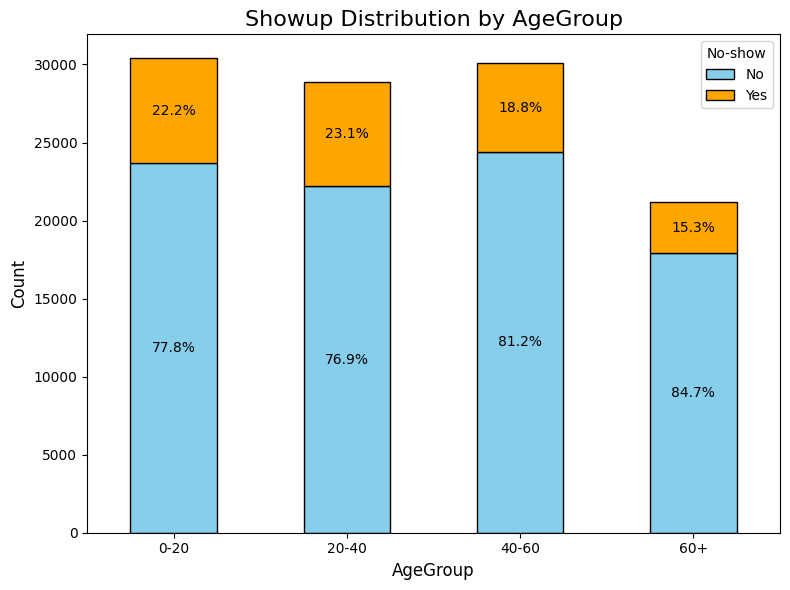

In [959]:
# Calculate counts for each combination of gender and showup
counts = data.groupby(['AgeGroup', 'No-show']).size().unstack(fill_value=0)

# Calculate percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Add percentage text on bars
for i, gender in enumerate(counts.index):
    total = counts.loc[gender].sum()
    for j, showup_status in enumerate(counts.columns):
        count = counts.loc[gender, showup_status]
        percentage = percentages.loc[gender, showup_status]
        if count > 0:
            ax.text(i, count - count / 2 if j == 0 else total - count / 2,  # Text position
                    f"{percentage:.1f}%", ha='center', va='center', color='black')

# Customize plot
plt.title('Showup Distribution by AgeGroup', fontsize=16)
plt.xlabel('AgeGroup', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='No-show', labels=counts.columns, fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Neighborhood**

Missing value detection

In [960]:
print(f"Number of missing value for Neighbourhood is {data['Age'].isna().sum()}")

Number of missing value for Neighbourhood is 0


Data preprocessing - oridinal Encoder

In [961]:
encoder = OrdinalEncoder()  # Ensure the correct order
data['NeighborhoodEncoded'] = encoder.fit_transform(data[['Neighbourhood']])

Distribution and relationship to the target

I tried to adjust the figure size to make it clear, but there are too many neighborhoods in this figure. But we can still see there is a relationship to the target value

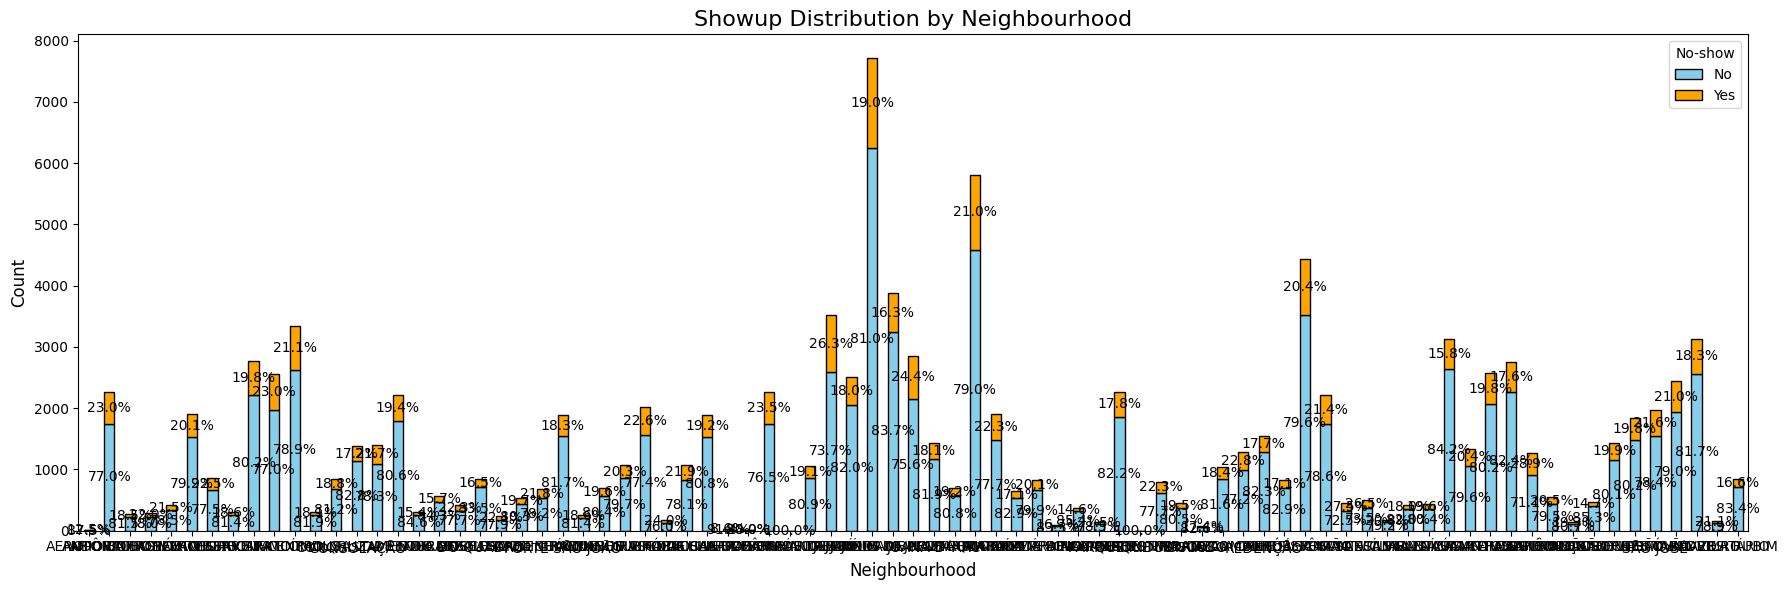

In [962]:
# Calculate counts for each combination of gender and showup
counts = data.groupby(['Neighbourhood', 'No-show']).size().unstack(fill_value=0)

# Calculate percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(18, 6))
counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Add percentage text on bars
for i, gender in enumerate(counts.index):
    total = counts.loc[gender].sum()
    for j, showup_status in enumerate(counts.columns):
        count = counts.loc[gender, showup_status]
        percentage = percentages.loc[gender, showup_status]
        if count > 0:
            ax.text(i, count - count / 2 if j == 0 else total - count / 2,  # Text position
                    f"{percentage:.1f}%", ha='center', va='center', color='black')

# Customize plot
plt.title('Showup Distribution by Neighbourhood', fontsize=16)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='No-show', labels=counts.columns, fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Scholarship**

Missing value detection

In [963]:
print(f"Number of missing value for Gender is {data['Age'].isna().sum()}")

Number of missing value for Gender is 0


Distribution and relationship to the target

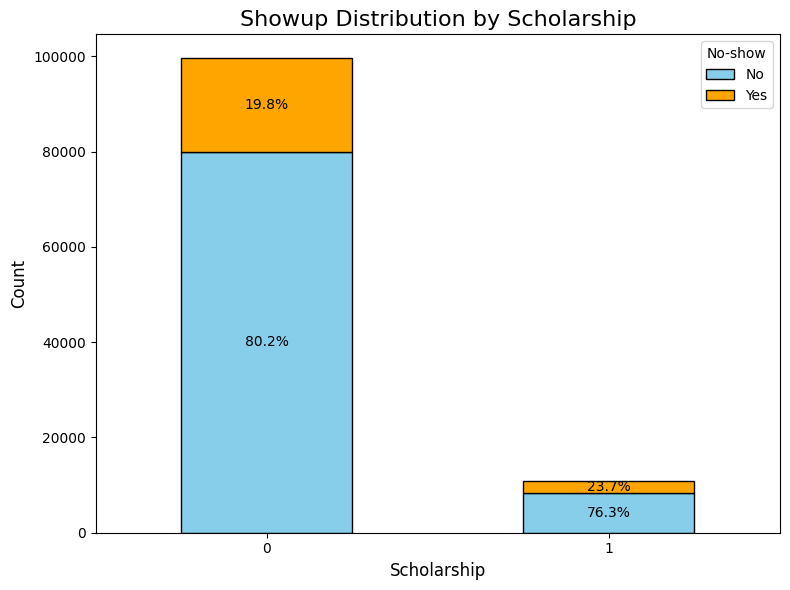

In [964]:
# Calculate counts for each combination of gender and showup
counts = data.groupby(['Scholarship', 'No-show']).size().unstack(fill_value=0)

# Calculate percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Add percentage text on bars
for i, gender in enumerate(counts.index):
    total = counts.loc[gender].sum()
    for j, showup_status in enumerate(counts.columns):
        count = counts.loc[gender, showup_status]
        percentage = percentages.loc[gender, showup_status]
        if count > 0:
            ax.text(i, count - count / 2 if j == 0 else total - count / 2,  # Text position
                    f"{percentage:.1f}%", ha='center', va='center', color='black')

# Customize plot
plt.title('Showup Distribution by Scholarship', fontsize=16)
plt.xlabel('Scholarship', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='No-show', labels=counts.columns, fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Hipertension**

Missing value detection

In [965]:
print(f"Number of missing value for Hipertension is {data['Hipertension'].isna().sum()}")

Number of missing value for Hipertension is 0


Distribution and relationshio to the target

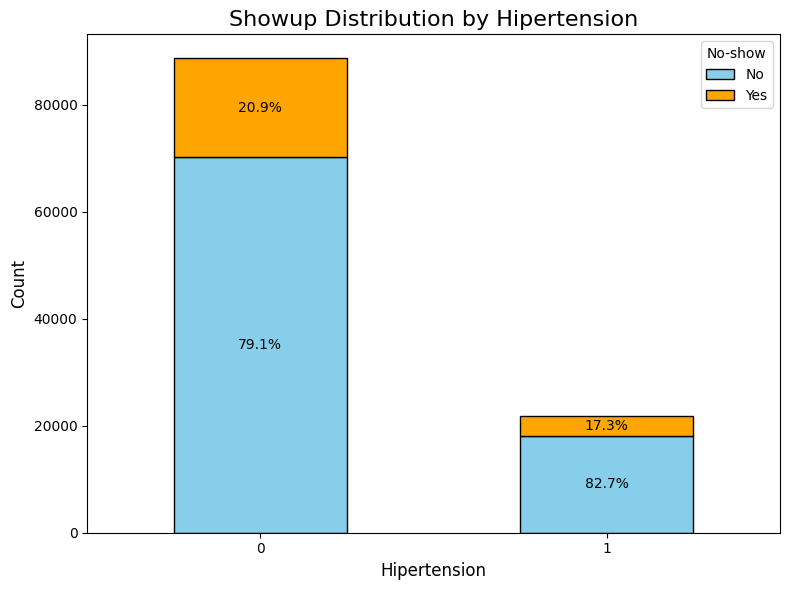

In [966]:
# Calculate counts for each combination of gender and showup
counts = data.groupby(['Hipertension', 'No-show']).size().unstack(fill_value=0)

# Calculate percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Add percentage text on bars
for i, gender in enumerate(counts.index):
    total = counts.loc[gender].sum()
    for j, showup_status in enumerate(counts.columns):
        count = counts.loc[gender, showup_status]
        percentage = percentages.loc[gender, showup_status]
        if count > 0:
            ax.text(i, count - count / 2 if j == 0 else total - count / 2,  # Text position
                    f"{percentage:.1f}%", ha='center', va='center', color='black')

# Customize plot
plt.title('Showup Distribution by Hipertension', fontsize=16)
plt.xlabel('Hipertension', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='No-show', labels=counts.columns, fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Diabetes**

Missing value detection

In [967]:
print(f"Number of missing value for Hipertension is {data['Diabetes'].isna().sum()}")

Number of missing value for Hipertension is 0


Distribution and relationshio to the target

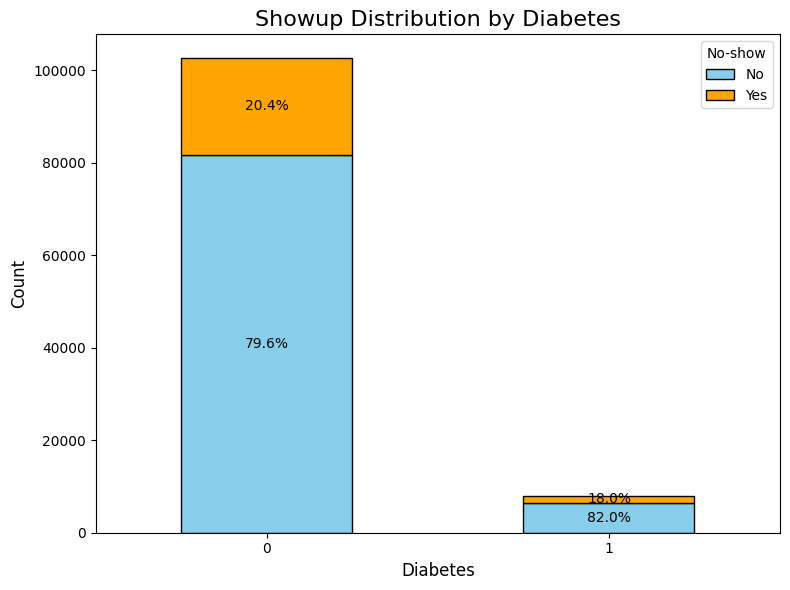

In [968]:
# Calculate counts for each combination of gender and showup
counts = data.groupby(['Diabetes', 'No-show']).size().unstack(fill_value=0)

# Calculate percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Add percentage text on bars
for i, gender in enumerate(counts.index):
    total = counts.loc[gender].sum()
    for j, showup_status in enumerate(counts.columns):
        count = counts.loc[gender, showup_status]
        percentage = percentages.loc[gender, showup_status]
        if count > 0:
            ax.text(i, count - count / 2 if j == 0 else total - count / 2,  # Text position
                    f"{percentage:.1f}%", ha='center', va='center', color='black')

# Customize plot
plt.title('Showup Distribution by Diabetes', fontsize=16)
plt.xlabel('Diabetes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='No-show', labels=counts.columns, fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**SMS_received**

Missing value detection

In [969]:
print(f"Number of missing value for Hipertension is {data['SMS_received'].isna().sum()}")

Number of missing value for Hipertension is 0


Distribution and relationshio to the target

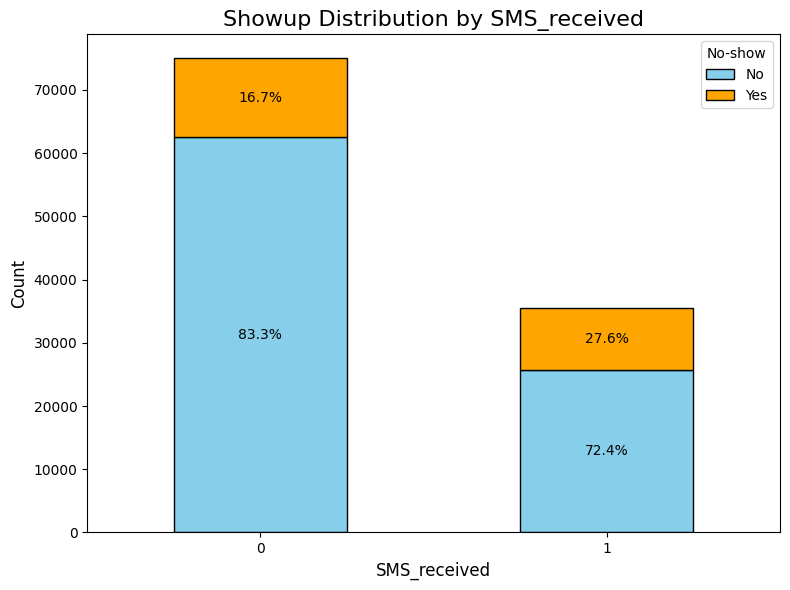

In [970]:
# Calculate counts for each combination of gender and showup
counts = data.groupby(['SMS_received', 'No-show']).size().unstack(fill_value=0)

# Calculate percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Add percentage text on bars
for i, gender in enumerate(counts.index):
    total = counts.loc[gender].sum()
    for j, showup_status in enumerate(counts.columns):
        count = counts.loc[gender, showup_status]
        percentage = percentages.loc[gender, showup_status]
        if count > 0:
            ax.text(i, count - count / 2 if j == 0 else total - count / 2,  # Text position
                    f"{percentage:.1f}%", ha='center', va='center', color='black')

# Customize plot
plt.title('Showup Distribution by SMS_received', fontsize=16)
plt.xlabel('SMS_received', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='No-show', labels=counts.columns, fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Time between appointment date and schedule date**

In [971]:
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])
data['AppointmentDiff'] = data.apply(lambda row: (row['AppointmentDay'] - row['ScheduledDay']).days, axis=1)


Correlation heat map

As shown below, there is no high correlated features

<Axes: >

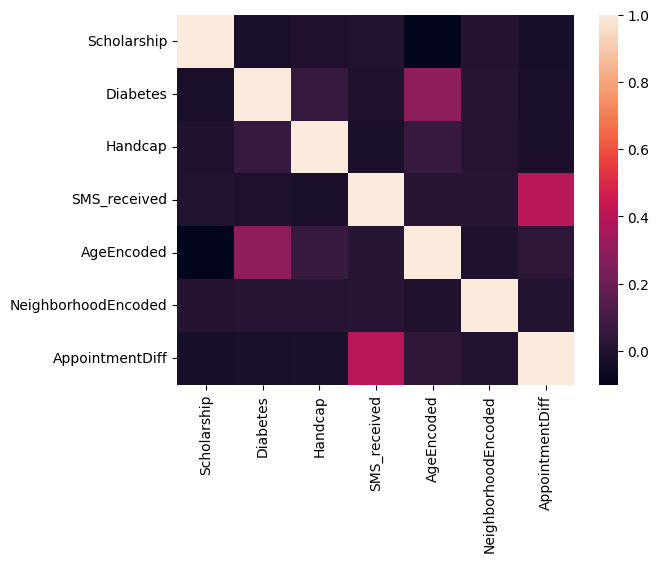

In [972]:
data['No-show'] = data['No-show'].map({'Yes': 1, 'No': 0})

X = data.copy()
X.drop(['No-show', 'ScheduledDay', 'AppointmentDay', 'AppointmentID', 'PatientId', 'Gender', 'Alcoholism', 'AgeGroup', 'Age', 'Neighbourhood', 'Hipertension'], axis=1, inplace=True)
y = data['No-show']

sns.heatmap(X.corr())

Train test data split

Utilized SMOTE for imbalanced data preprocessing

Utilized StandardScaler on input data to avoid Logistic Regression hitting the maximum number of iterations allowed before fully converging

In [973]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=241)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)  # Training data
print(X_test.shape, y_test.shape)  # Test data

(149953, 7) (149953,)
(26463, 7) (26463,)


Build the prediction model and use 10-fold cross validation (17 pts)
1. using Logistic Regression

In [974]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_lr_prob = lr_model.predict_proba(X_test)[:,1]

# Evaluate the model
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=10, scoring="accuracy")

# Print the results
print(f"10-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

10-Fold Cross-Validation Scores: [0.63023473 0.63870365 0.63176847 0.62907636 0.63227743 0.62887629
 0.63441147 0.63007669 0.62720907 0.62734245]
Mean Score: 0.6310
Standard Deviation: 0.0033


2. using Decision Tree

In [975]:
dt_model = DecisionTreeClassifier(random_state=24)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_dt_prob = dt_model.predict_proba(X_test)[:,1]

# Evaluate the model
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=10, scoring="accuracy")

# Print the results
print(f"10-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

10-Fold Cross-Validation Scores: [0.75353428 0.75453454 0.7521339  0.74698233 0.75405135 0.74884962
 0.74904968 0.74864955 0.75025008 0.74771591]
Mean Score: 0.7506
Standard Deviation: 0.0026


3. Random Forest

In [976]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=24)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_prob = rf_model.predict_proba(X_test)[:,1]

# Evaluate the model
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring="accuracy")

# Print the results
print(f"10-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

10-Fold Cross-Validation Scores: [0.75693518 0.75660176 0.75380101 0.74738246 0.75691897 0.75578526
 0.75251751 0.75405135 0.75045015 0.75251751]
Mean Score: 0.7537
Standard Deviation: 0.0029


Report the following metrics: Precision, Recall, F-Score, AUC, Plot the ROC curve (20 points)

Logistic RegressionClassification Report:
              precision    recall  f1-score   support

           0       0.61      0.71      0.65     13182
           1       0.65      0.55      0.60     13281

    accuracy                           0.63     26463
   macro avg       0.63      0.63      0.63     26463
weighted avg       0.63      0.63      0.63     26463

Decision TreeClassification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     13182
           1       0.76      0.76      0.76     13281

    accuracy                           0.75     26463
   macro avg       0.75      0.75      0.75     26463
weighted avg       0.75      0.75      0.75     26463

Random ForestClassification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75     13182
           1       0.75      0.78      0.76     13281

    accuracy                           0.76     26463
   macro avg  

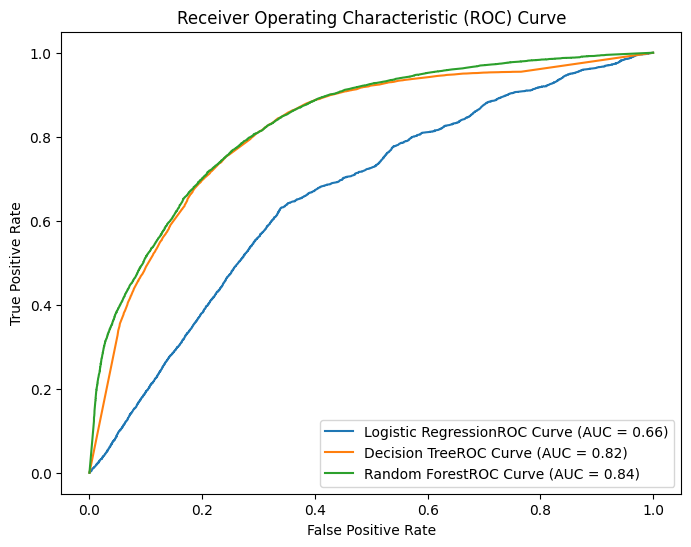

In [977]:
# Plot the ROC Curve
plt.figure(figsize=(8, 6))
for model_name, y_pred, y_pred_prob in [("Logistic Regression", y_pred_lr, y_pred_lr_prob),
  ("Decision Tree", y_pred_dt, y_pred_dt_prob),
  ("Random Forest", y_pred_rf, y_pred_rf_prob)]:
  print(model_name + "Classification Report:")
  print(classification_report(y_test, y_pred))
  # Compute AUC
  auc_score = roc_auc_score(y_test, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  plt.plot(fpr, tpr, label=model_name + f"ROC Curve (AUC = {auc_score:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Q3

To transfer the regression problem of predicting the length of stay to classification problem, follow these step below

1. Analyze the distribution of Data and define categories
  
  By observing the distribution of data and understand our demand. We can split the distrubution into different categories. For an example, we could categorize the data into three groups [0-1, 2-3, 3+] by the length of stay.
  But this is mainly on our prediction demand. If we want to predict exact number of time, we could categorize like [0,1,2,3,4,5,6,7+]

2. labels those categories

  The final step is giving each category a label so that machien would understand. An optional step is using categorical encoder to transfer these string values into binary values. For an example, I will label 0-1 as short_stay, 2-3 as a medium_stay, 3+ as long_stay. Further more, if adding encoder. 0-1 would be 1, 1-2 would be 2, 3+ would be 3.

Here is a pd.cut example on how to label numerical data into categorical data

In [978]:
import pandas as pd
import numpy as np

# Example data
data = {'LengthOfStay': [1, 3, 8, 2, 2, 3, 2, 0, 5, 4]}
df = pd.DataFrame(data)

# Define bins and labels
bins = [0, 2, 4, np.inf]  # Intervals
labels = ['short_stay', 'medium_stay', 'long_stay']

# Create the 'StayCategory' column
df['StayCategory'] = pd.cut(df['LengthOfStay'], bins=bins, labels=labels, right=False)

print(df)

   LengthOfStay StayCategory
0             1   short_stay
1             3  medium_stay
2             8    long_stay
3             2  medium_stay
4             2  medium_stay
5             3  medium_stay
6             2  medium_stay
7             0   short_stay
8             5    long_stay
9             4    long_stay
